In [1]:
from pathlib import Path
from functools import partial

from utils import load_polar

import pybem as pb
import numpy as np
import pandas as pd
import proplot as plot

Inputs

In [2]:
PATH_POLARS = Path("../polars")
file_lift = "lift.csv"
file_drag = "drag.csv"
file_propeller = PATH_POLARS / "propeller1_inches.txt"

PITCH = 32.4  # inches

In [3]:
INCH_METER = 0.0254
PITCH = INCH_METER * PITCH  # meters

In [4]:
csv_reader = partial(pd.read_csv, sep=";", index_col=None)
load_polar = partial(
    load_polar,
    path=PATH_POLARS,
    file_lift=file_lift,
    file_drag=file_drag,
    reader=csv_reader,
)

In [5]:
dimensions_original_df = pd.read_csv(filepath_or_buffer=file_propeller, sep=",")

# Enforce stripped columns
dimensions_original_df.columns = [col.strip() for col in dimensions_original_df.columns]
dimensions_original_df = dimensions_original_df[["radius", "chord"]]

# Convert to international units
dimensions_original_df = dimensions_original_df.mul(INCH_METER)

# Name
dimensions_original_df.index = ["Hub", "S1", "S2", "S3", "S4", "Tip"]

Create the blade by defining the sections at each stage.

In [6]:
def generate_sections(coefficient, dimensions_original):
    
    dimensions_df = dimensions_original.copy()
    
    # Scale the propeller size and compute theta
    dimensions_df["radius"] *= coefficient
    
    for idx, row in dimensions_df.iterrows():

        r = row["radius"]

        # Constant pitch law
        tan_theta = PITCH / (2.0 * np.pi * r)
        theta = np.arctan(tan_theta)  # radians
        theta = np.rad2deg(theta)  # degrees

        dimensions_df.loc[idx, "theta"] = theta

    # Define known sections
    sections = [
        pb.Section(
            name="Hub",
            r=dimensions_df.loc["Hub", "radius"],
            beta=dimensions_df.loc["Hub", "theta"],
            chord=dimensions_df.loc["Hub", "chord"],
            airfoil=pb.Airfoil(
                polar_cl=load_polar(airfoil_type="765", which="cl"),
                polar_cd=load_polar(airfoil_type="765", which="cd"),
            ),
        ),
        pb.Section(
            name="S1",
            r=dimensions_df.loc["S1", "radius"],
            beta=dimensions_df.loc["S1", "theta"],
            chord=dimensions_df.loc["S1", "chord"],
            airfoil=pb.Airfoil(
                polar_cl=load_polar(airfoil_type="765", which="cl"),
                polar_cd=load_polar(airfoil_type="765", which="cd"),
            ),
        ),
        pb.Section(
            name="S2",
            r=dimensions_df.loc["S2", "radius"],
            beta=dimensions_df.loc["S2", "theta"],
            chord=dimensions_df.loc["S2", "chord"],
            airfoil=pb.Airfoil(
                polar_cl=load_polar(airfoil_type="764", which="cl"),
                polar_cd=load_polar(airfoil_type="764", which="cd"),
            ),
        ),
        pb.Section(
            name="S3",
            r=dimensions_df.loc["S3", "radius"],
            beta=dimensions_df.loc["S3", "theta"],
            chord=dimensions_df.loc["S3", "chord"],
            airfoil=pb.Airfoil(
                polar_cl=load_polar(airfoil_type="763", which="cl"),
                polar_cd=load_polar(airfoil_type="763", which="cd"),
            ),
        ),
        pb.Section(
            name="S4",
            r=dimensions_df.loc["S4", "radius"],
            beta=dimensions_df.loc["S4", "theta"],
            chord=dimensions_df.loc["S4", "chord"],
            airfoil=pb.Airfoil(
                polar_cl=load_polar(airfoil_type="762", which="cl"),
                polar_cd=load_polar(airfoil_type="762", which="cd"),
            ),
        ),
        pb.Section(
            name="Tip",
            r=dimensions_df.loc["Tip", "radius"],
            beta=dimensions_df.loc["Tip", "theta"],
            chord=dimensions_df.loc["Tip", "chord"],
            airfoil=pb.Airfoil(
                polar_cl=load_polar(airfoil_type="761", which="cl"),
                polar_cd=load_polar(airfoil_type="761", which="cd"),
            ),
        ),
    ]
    
    return sections

In [18]:
# Define propeller
COEFF_0 = 0.25
COEFF_N = 5.0
N = 10

results = []
for coeff in np.linspace(start=COEFF_0, stop=COEFF_N, num=N):

    sections = generate_sections(
        coefficient=coeff, dimensions_original=dimensions_original_df
    )

    propeller = pb.Propeller(B=2, sections=sections)

    # Define flow conditions and BEM method

    for J in np.linspace(1e-1, 1.5):

        pi = np.pi

        _lambda = J / pi

        bem = pb.BladeElementMethod(
            _lambda=_lambda, propeller=propeller, tip_loss=True, hub_loss=False
        )

        try:
            # Solve
            bem.solve()
            CT, CQ = bem.integrate_forces()
        except:
            CT = np.nan
            CQ = np.nan

        R = propeller.R
        
        # Create experiments non-dimensionless coefficients
        results.append(
            (
                R,
                J,
                CT * (pi ** 3.0) / 4 / J ** 2.0,
                CQ * (pi ** 4.0) / 4 / J ** 2.0,
                _lambda * CT / CQ,  # efficiency
            )
        )

        del bem

    del propeller

results_df = pd.DataFrame(results, columns=["R", "J", "CT", "CP", "eta"]).dropna()

/opt/anaconda3/envs/pybem/lib/python3.8/site-packages/scipy/optimize/nonlin.py:472: RuntimeWarning: invalid value encountered in double_scalars
  and dx_norm/self.x_rtol <= x_norm))


In [19]:
results_df

,R,J,CT,CP,eta
40,0.1143,1.242857,0.300111,0.785028,0.475135
41,0.1143,1.271429,0.288512,0.759210,0.483163
42,0.1143,1.300000,0.277106,0.734269,0.490607
43,0.1143,1.328571,0.265919,0.709913,0.497657
44,0.1143,1.357143,0.255122,0.686319,0.504484
...,...,...,...,...,...
450,2.2860,0.100000,1.085901,0.330150,0.328912
451,2.2860,0.128571,0.607559,0.201892,0.386913
452,2.2860,0.157143,0.372117,0.136063,0.429769
453,2.2860,0.185714,0.239875,0.097517,0.456824


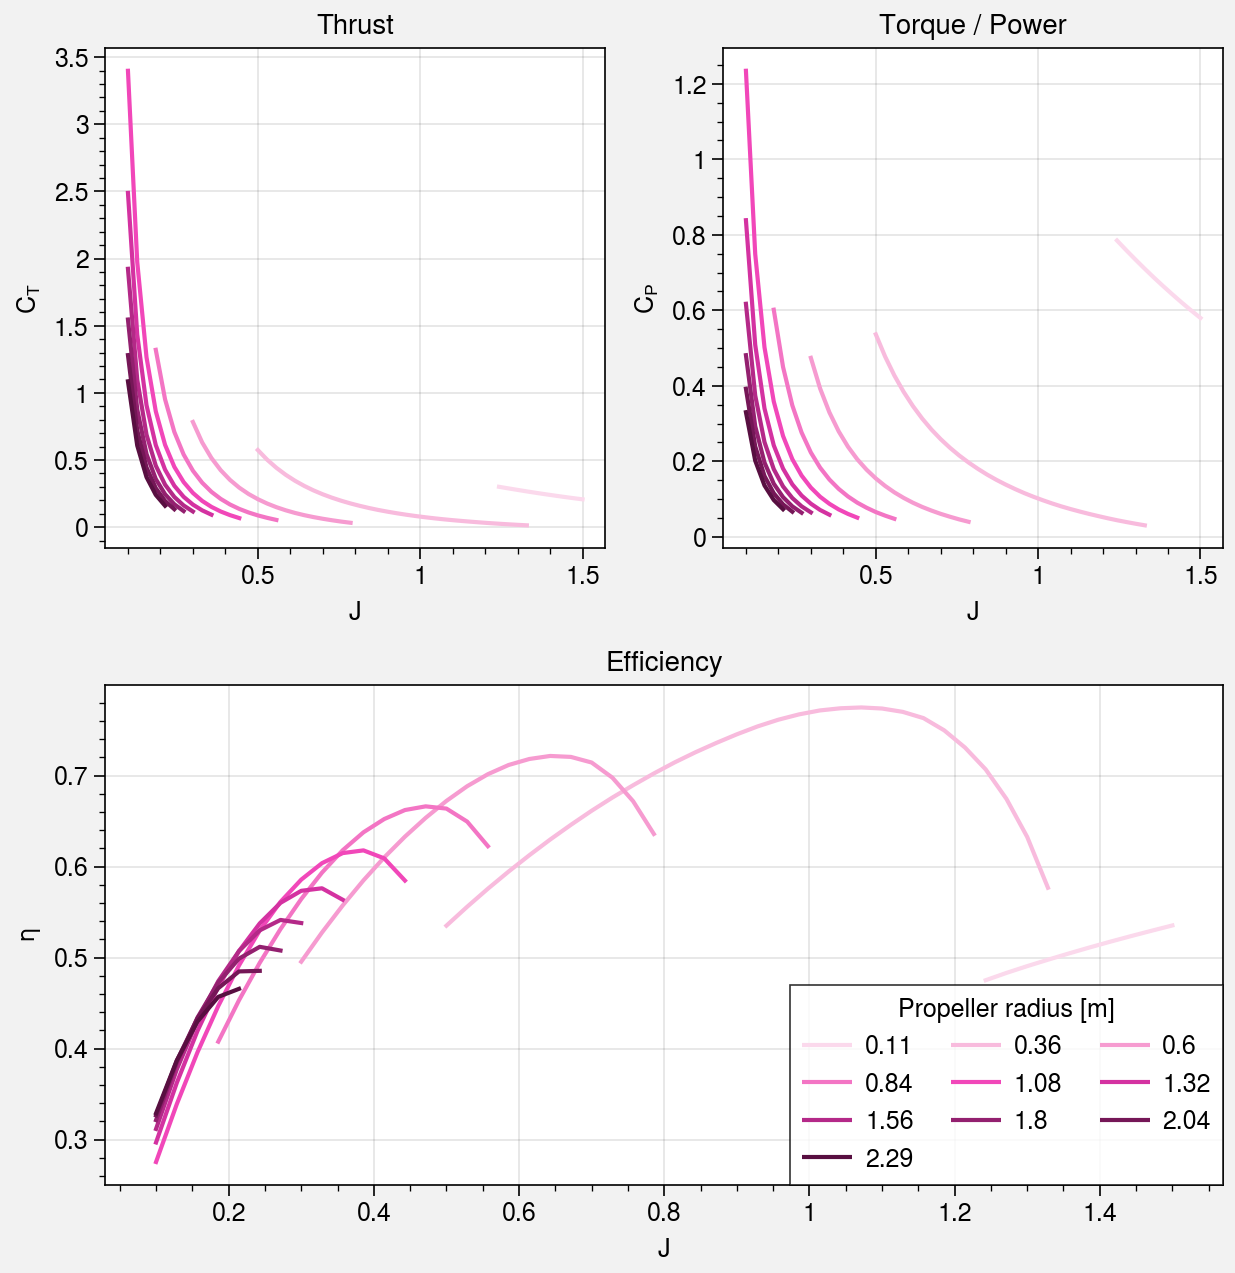

In [20]:
_array = [[1, 2], [3, 3]]
fig, axes = plot.subplots(array=_array, share=0)

Rs = results_df["R"].unique()
for R in Rs:

    mask = results_df["R"] == R
    _results_df = results_df.loc[mask].set_index("J").drop("R", axis=1)

    name = np.round(R, 2)
    name = str(name)
    ############
    # Thrust
    ############
    ax = axes[0]
    thrust = _results_df["CT"]
    thrust.name = name
    lines = ax.plot(
        thrust,
        cycle="plum",
    )
    ax.format(
        title="Thrust",
        ylabel="$C_T$",
    )

    ############
    # Torque
    ############
    ax = axes[1]
    torque = _results_df["CP"]
    torque.name = name

    ax.plot(
        torque,
        cycle="plum",
    )
    ax.format(
        title="Torque / Power",
        ylabel="$C_P$",
    )

    ############
    # Efficiency
    ############
    ax = axes[-1]
    eta = _results_df["eta"]
    eta.name = name
    ax.plot(eta, cycle="plum")
    ax.format(title="Efficiency", ylabel="$\eta$")

axes[-1].legend(title="Propeller radius [m]")

fig.save("Radius.pdf")